In [15]:
import pandas as pd 
import numpy as np
import seaborn as sns

%pylab inline
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 15})

AgentType = ["poorHigh","poorLow","richHigh","richLow"]
Beta_r = [0.10]
Gamma = [4.0]

Populating the interactive namespace from numpy and matplotlib


/home/dli36/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [16]:
import jax.numpy as jnp
T_min = 0
T_max = 60
# variable associated with housing and mortgage 
# age limit of buying a house
ageLimit = 30
mortgageLength = 30
# mortgage rate 
rh = 0.045
# housing unit
H = 1000
# max rent unit
Rl = 500
# housing price constant 
pt = 2*250/1000 / 5 * 4.3
# 30k rent 1000 sf
pr = 2*10/1000 * 2 / 5 * 4.3
# constant cost 
c_h = 5
c_s = H*pt*0.4
# Dm is used to update the mortgage payment
Dm = [(1+rh) - rh*(1+rh)**(T_max - t)/((1+rh)**(T_max-t)-1) for t in range(T_min, T_max)]
Dm[-1] = 0
Dm = jnp.array(Dm)
# 30 year mortgage
Ms = []
M = H*pt*0.8
m = M*(1+rh) - Dm[30]*M
for i in range(30, T_max):
    Ms.append(M)
    M = M*(1+rh) - m
Ms.append(0)
Ms = jnp.array(Ms)


In [17]:
# get the empirical part ready
Fdf = pd.read_csv("familyData.csv")
codes = {'employed':1, 'unemployed': 0, "retired": 0}
Fdf["employmentStatus"] = Fdf["employmentStatus"].map(codes)
codes = {'owner':1, 'renter': 0}
Fdf["ownership"] = Fdf["ownership"].map(codes)

years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019]
def outputVariables(waseozcbkhmType):
    output = []
    for i in range(waseozcbkhmType[0].shape[0]):
        output.append(np.concatenate((waseozcbkhmType[0][i],waseozcbkhmType[1][i],waseozcbkhmType[2][i],waseozcbkhmType[3][i]), axis = 1))
    return output

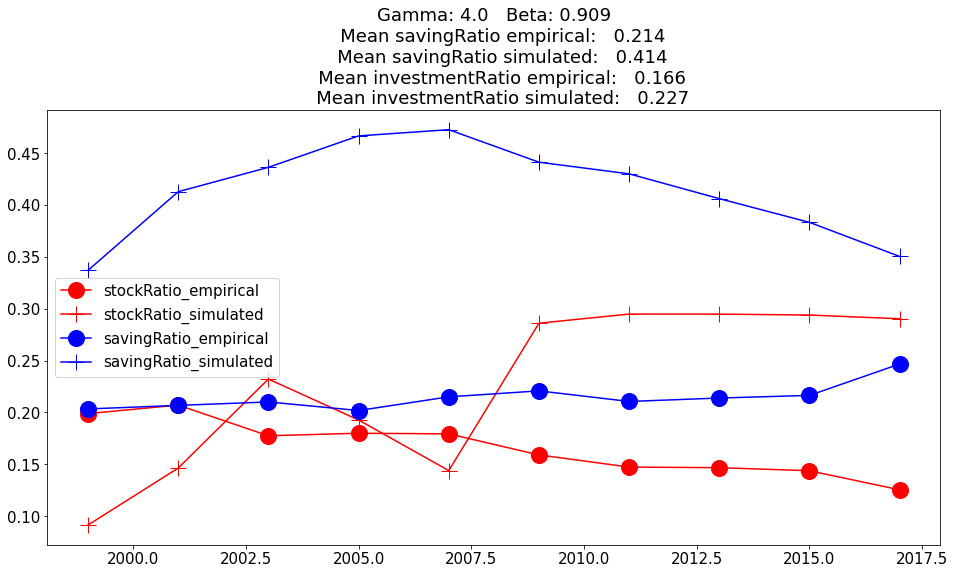

In [18]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        # generate comparison plots between empirical and simulated variables
        plt.figure()
        stockRatio_empirical = []
        savingRatio_empirical = []
        stockRatio_simulated = []
        savingRatio_simulated = []
        for year in years[:-1]:  
            df = Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]
            stockRatio_empirical.append((df.investmentAmount / (df.liquidWealth + df.investmentAmount)).mean())
            savingRatio_empirical.append(((df.liquidWealth + df.investmentAmount)/(df.totalExpense + df.liquidWealth + df.investmentAmount)).mean())
            w = wwww[year - years[0],:]
            b = bbbb[year - years[0],:]
            k = kkkk[year - years[0],:]
            c = cccc[year - years[0],:]
            o = oooo[year - years[0],:]
            stockRatio_simulated.append((k/(b+k)).mean())
            savingRatio_simulated.append(((b+k)/((c+c*(3/7)*o)+b+k)).mean())
        meanSaving_empirical = round(np.mean(savingRatio_empirical), 3)
        meanInvestment_empirical = round(np.mean(stockRatio_empirical), 3)
        meanSaving_simulated = round(np.mean(savingRatio_simulated), 3)
        meanInvestment_simulated = round(np.mean(stockRatio_simulated), 3)
        plt.title("Gamma: " + str(gamma) +  "   Beta: " + str(round(1/(1+beta_r),3)) + 
                  "\n   Mean savingRatio empirical:   " + str(meanSaving_empirical) +
                  "\n   Mean savingRatio simulated:   " + str(meanSaving_simulated) +
                  "\n   Mean investmentRatio empirical:   " + str(meanInvestment_empirical) +
                  "\n   Mean investmentRatio simulated:   " + str(meanInvestment_simulated) 
                 )
        plt.plot(years[:-1], stockRatio_empirical, 'ro-', label = "stockRatio_empirical", markersize = 16)
        plt.plot(years[:-1], stockRatio_simulated, 'r+-', label = "stockRatio_simulated", markersize = 16)
        plt.plot(years[:-1], savingRatio_empirical, 'bo-', label = "savingRatio_empirical", markersize = 16)
        plt.plot(years[:-1], savingRatio_simulated, 'b+-', label = "savingRatio_simulated", markersize = 16)
        plt.legend()

In [19]:
wealthLevel = []
consumption = []
investmentStock = []
bondOrcash = []
annuityAmount = []
participation = []
ownershipStatus = []
employment = []

for year in years:
    wealthLevel.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["wealthWithoutHomeEquity"].values)
    investmentStock.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["investmentAmount"].values)
    consumption.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["totalExpense"].values)
    bondOrcash.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["liquidWealth"].values)
    annuityAmount.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["annuityIRA"].values)
    participation.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["participation"].mean())
    ownershipStatus.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["ownership"].mean())
    employment.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["employmentStatus"].mean())

In [20]:
def tsplot(x, y, lab, n=2, percentile_min=25, percentile_max=75, color='r', plot_mean=False, plot_median=True, line_color='k'):
    # calculate the lower and upper percentile groups, skipping 50 percentile
    perc1 = []
    perc2 = []
    meanValue = []
    medianValue = []
    for i in range(len(y)):
        perc1.append(np.percentile(y[i], np.linspace(percentile_min, 50, num=n, endpoint=False), axis=0))
        perc2.append(np.percentile(y[i], np.linspace(50, percentile_max, num=n+1)[1:], axis=0))
        meanValue.append(np.mean(y[i]))
        medianValue.append(np.median(y[i]))
    perc1 = np.array(perc1).T
    perc2 = np.array(perc2).T
    alpha = 1/n
    # fill lower and upper percentile groups
    for p1, p2 in zip(perc1, perc2):
        plt.fill_between(x, p1, p2, alpha=alpha, color=color, edgecolor=None)


    if plot_mean:
        plt.plot(x, meanValue, color=line_color,label = lab)


    if plot_median:
        plt.plot(x, medianValue, color=line_color,label = lab)
    
    return plt.gca()

<ipython-input-21-382f349cb48c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tsplot(years,(np.array(investmentStock) + np.array(bondOrcash)),"liquidWealth_empirical",color="b", line_color="b", percentile_min=25, percentile_max=75,plot_mean=True)


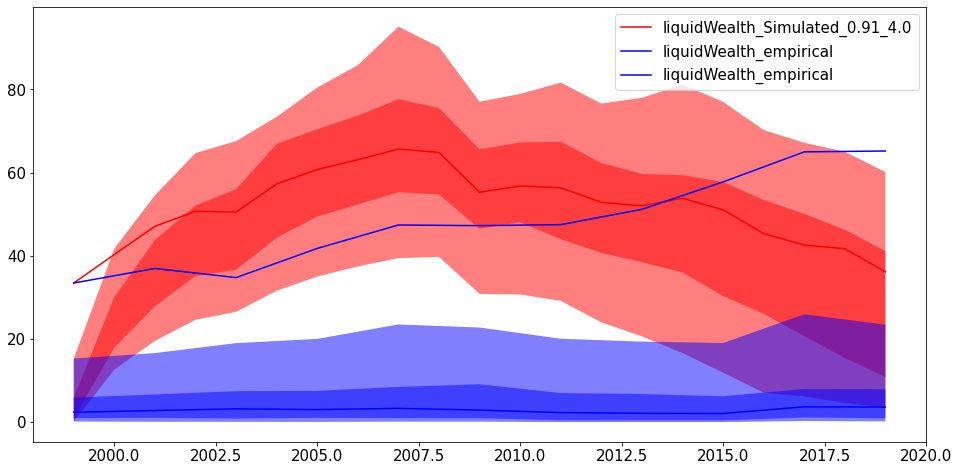

In [21]:
Beta_r = [0.1]
Gamma = [4.0]
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
    Label = "liquidWealth_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma)
    tsplot(range(1999,2020), wwww, Label, color="r", line_color="r", plot_mean=True, plot_median=False)
tsplot(years,(np.array(investmentStock) + np.array(bondOrcash)),"liquidWealth_empirical",color="b", line_color="b", percentile_min=25, percentile_max=75,plot_mean=True)
plt.legend()

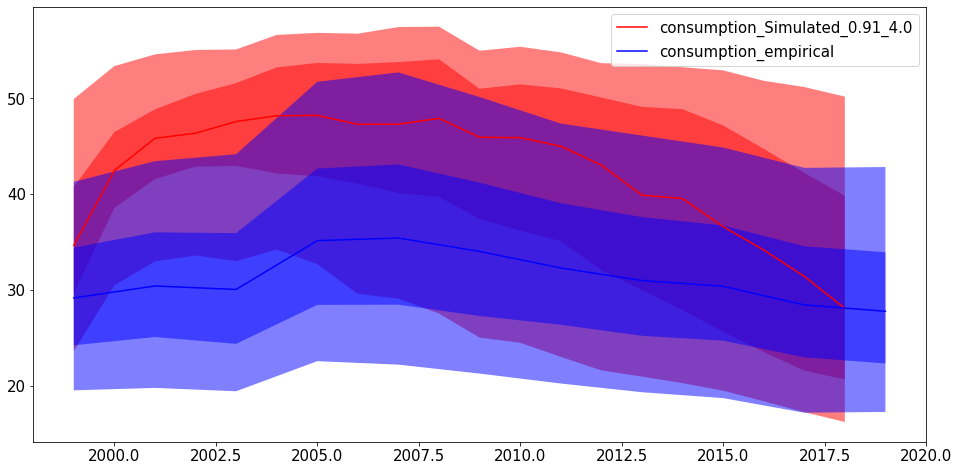

In [22]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        Label = "consumption_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma)
        tsplot(range(1999,2019), cccc, Label, color="r", line_color="r")
tsplot(years,consumption, "consumption_empirical",color="b", line_color="b")
plt.legend()

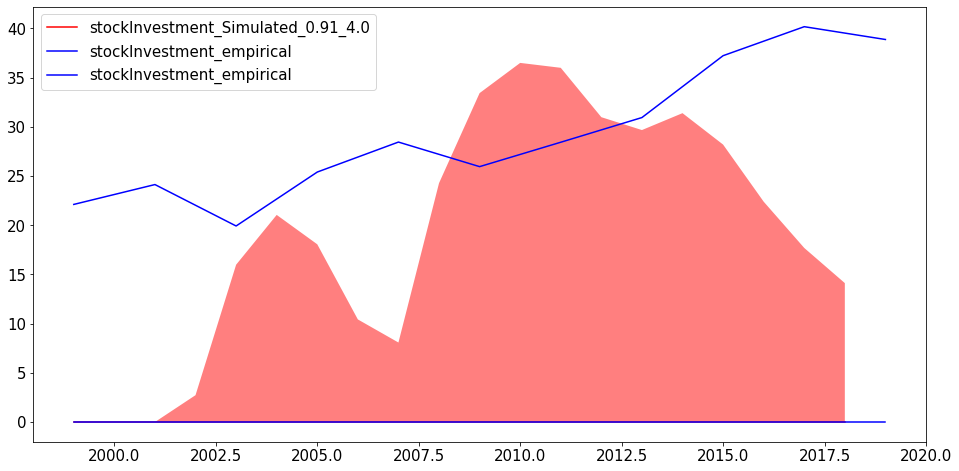

In [23]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        Label = "stockInvestment_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma)
        tsplot(range(1999,2019), kkkk, Label, color="r", line_color="r")
tsplot(years,investmentStock,"stockInvestment_empirical",percentile_min = 25, percentile_max = 75,color="b", line_color="b",plot_mean=True)
plt.legend()

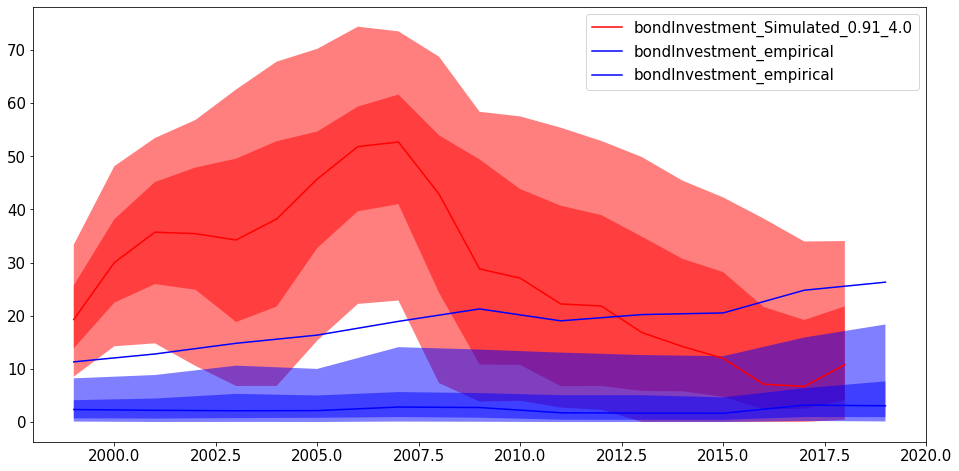

In [24]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        Label = "bondInvestment_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma)
        tsplot(range(1999,2019), bbbb, Label, color="r", line_color="r")       
tsplot(years,bondOrcash,"bondInvestment_empirical", color="b", line_color="b",plot_mean=True)
plt.legend()

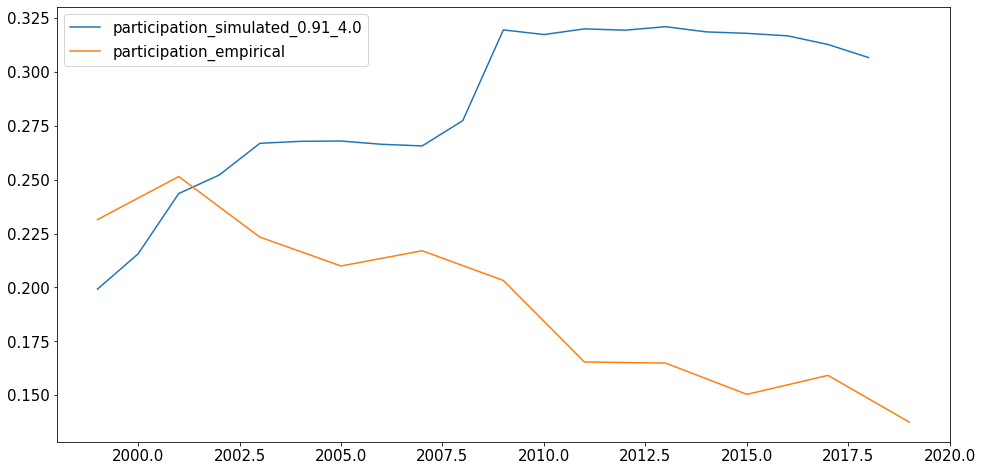

In [25]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2019), (kkkk>0).mean(axis = 1), label = "participation_simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,participation, label = "participation_empirical")
plt.legend()

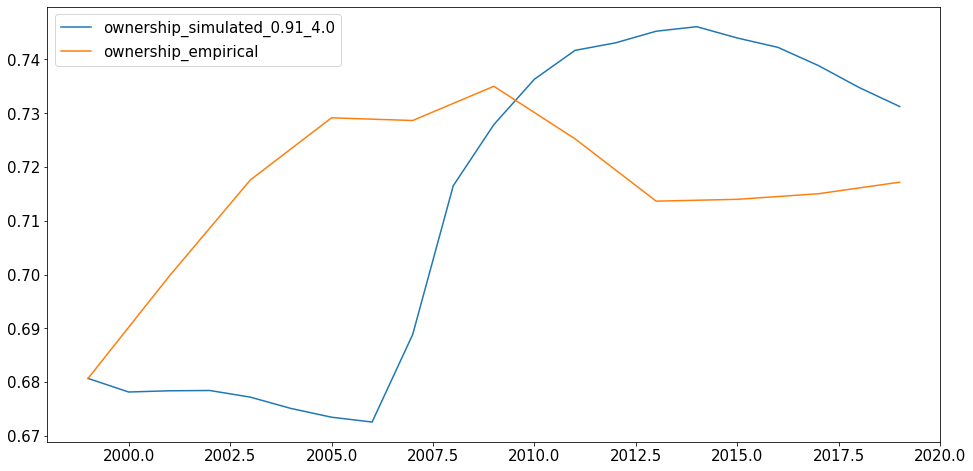

In [26]:
Beta_r = [0.1]
Gamma = [4.0]
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2020), oooo.mean(axis = 1), label = "ownership_simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,ownershipStatus, label = "ownership_empirical")
plt.legend()

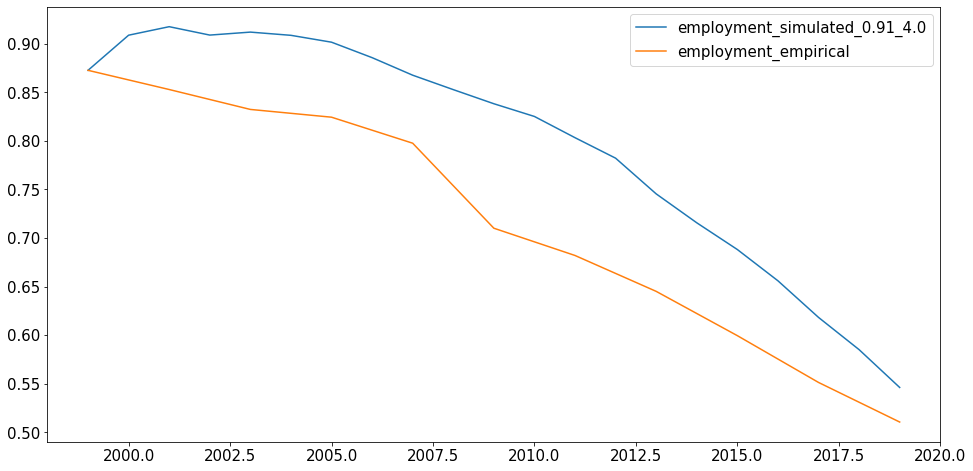

In [27]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2020), eeee.mean(axis = 1), label = "employment_simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
# fix here the retirment people is unemployed. 
plt.plot(years,employment, label = "employment_empirical")
plt.legend()

### cross age simulation 

0.5


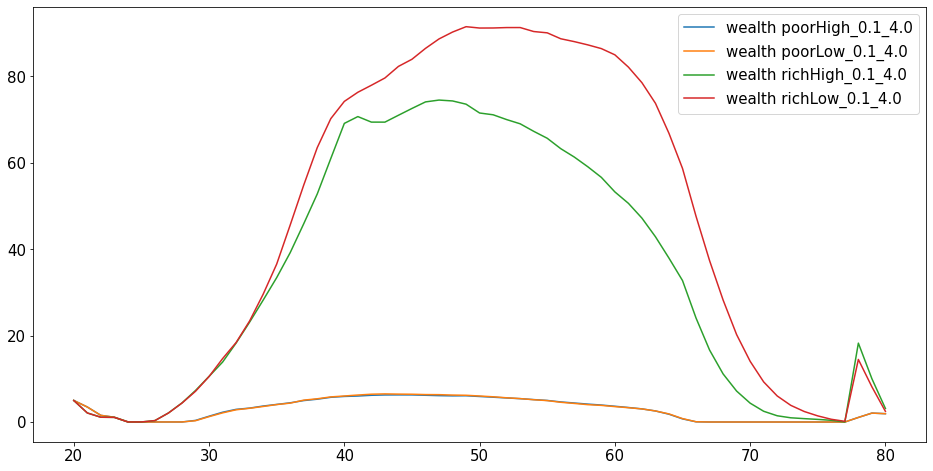

In [29]:
T_max = 60
# housing unit
H = 1000
# housing price constant 
pt = 2*250/1000
Gamma = [4.0]
Beta_r = [0.1]
print(pt)
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.plot(range(startAge, T_max + startAge+1),np.mean(wwww,axis = 1), label = "wealth " + fileName)
plt.legend()

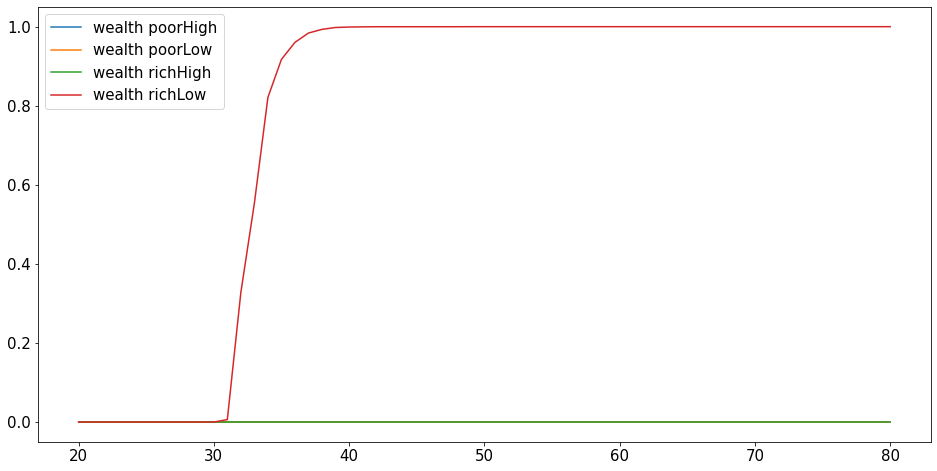

In [30]:
plt.figure()
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.plot(range(startAge, T_max + startAge+1),np.mean(zzzz,axis = 1), label = "wealth " + agentType)
plt.legend()

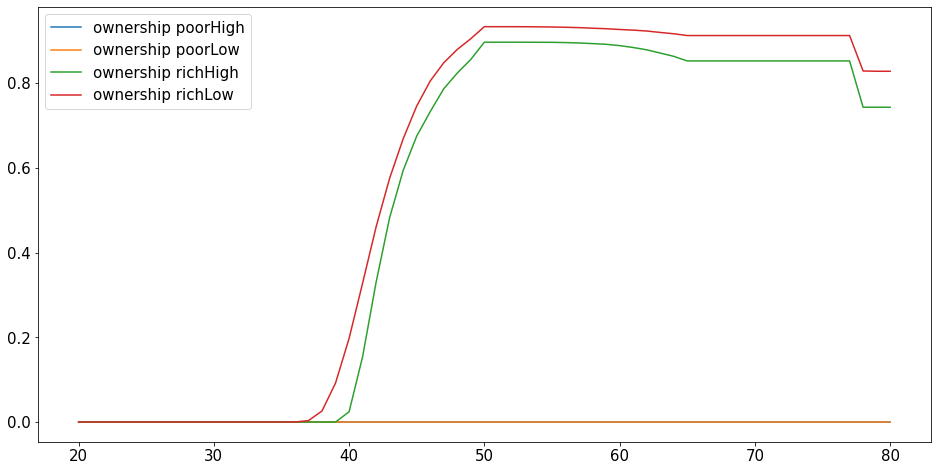

In [31]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.plot(range(startAge, T_max + startAge+1),np.mean(oooo,axis = 1), label = "ownership " + agentType)
plt.legend()

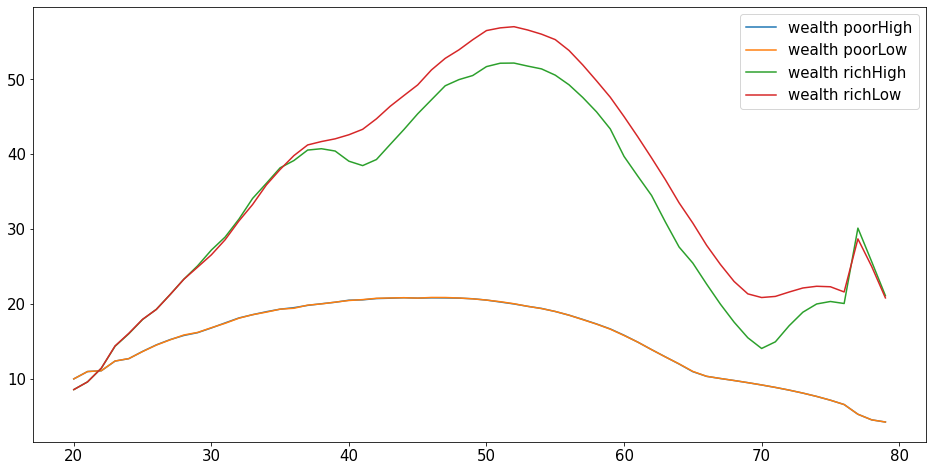

In [32]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.plot(range(startAge, T_max + startAge),np.mean(cccc,axis = 1), label = "wealth " + agentType)
plt.legend()

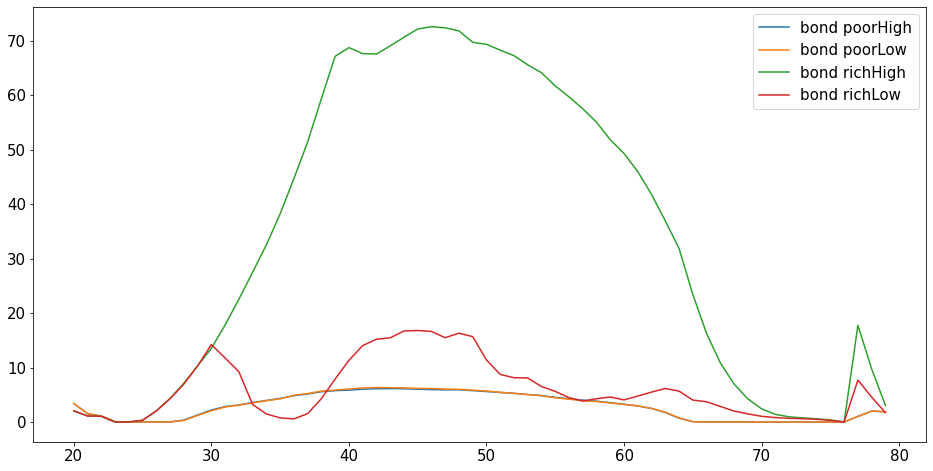

In [33]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.plot(range(startAge, T_max + startAge),np.mean(bbbb,axis = 1), label = "bond " + agentType)
plt.legend()

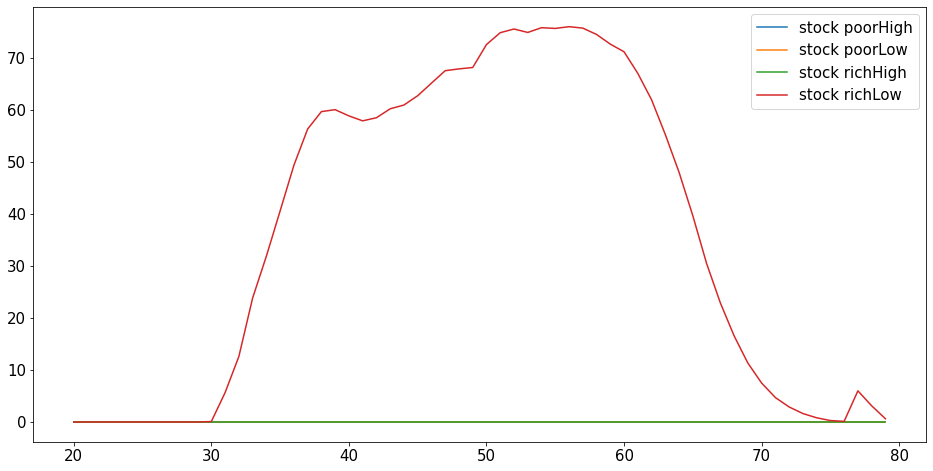

In [34]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.plot(range(startAge, T_max + startAge),np.mean(kkkk,axis = 1), label = "stock " + agentType)
plt.legend()

In [35]:
import jax.numpy as jnp 

In [36]:
'''
    Economic state calibration 
'''
# Define transition matrix of economical states S
Ps = jnp.array([[0.666943845910281,       0.323002783576127,       0.006773126343361,       0.003280244170230],
                [0.242744495621321,       0.552652993374488,       0.062441903606298,       0.142160607397893],
                [0.142160607397893,       0.062441903606298,       0.552652993374488,       0.242744495621321],
                [0.003280244170230,       0.006773126343361,       0.323002783576127,       0.666943845910281]])
# The possible GDP growth, stock return, bond return
gkfe = jnp.array([[1.15092702581186,0.35018029597671,7.45225509799324,1.96256037691487,2.70289403208730,4.08113333370979,6.38900780341802,6.58200153822790,75.7204565759835],
                    [4.04067574816344,1.52018766753626,11.0127698466567,5.36898678622499,2.74215830217707,4.84525964423984,5.75640718766578,6.41575253485291,76.0184702813153],
                    [1.15092702581186,3.94493112442431,8.01817936174009,1.90525394712031,3.52960682058264,7.20574800383753,6.28203807210335,7.44409304613654,77.1793373563495],
                    [4.04067574816344,5.11493849598385,11.5786941104035,5.31168035643043,3.56887109067241,7.96987431436759,5.64943745635110,7.27784404276155,77.4773510616813]])
# GDP growth depending on current S state
gGDP = gkfe[:,0]/100
# risk free interest rate depending on current S state 
r_b = gkfe[:,1]/100
# stock return depending on current S state
r_k = jnp.array([-0.09,  0.04,  0.12,  0.2 ,  0.33])
pk = jnp.array([0.2, 0.2, 0.2, 0.2, 0.2])
# unemployment rate depending on current S state 
Pe = gkfe[:,7:]/100
Pe = Pe[:,::-1]
# consumption lower boundary 
c_bar = jnp.array(np.load("constant/c_bar.npy"))

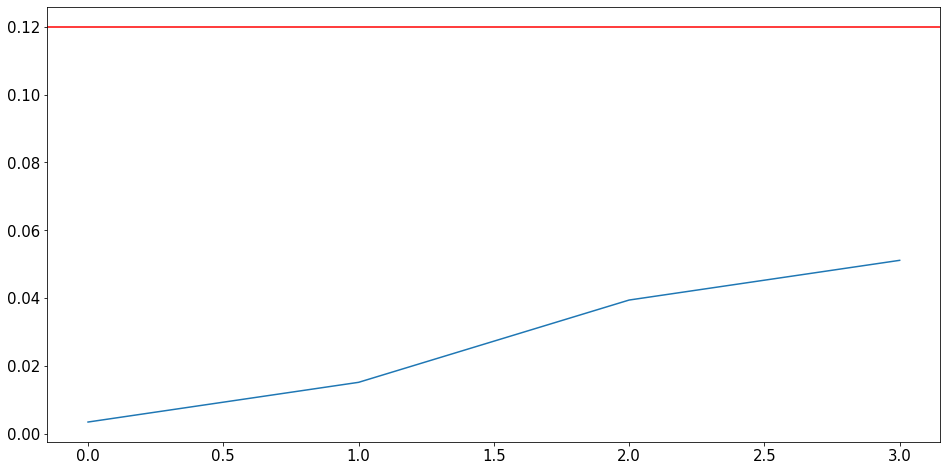

In [37]:
plt.plot(r_b)
plt.axhline(r_k.mean(), color='r', linestyle='-')

In [38]:
r_k.mean()

DeviceArray(0.12, dtype=float32)

In [39]:
np.std(r_k)

DeviceArray(0.14212671, dtype=float32)